# The goal of this exercise is to create a model that can identify physicians (NPIs) which are cardiologists using datasets containing drug and procedure utilization.

## Dataset info

* hcpcs_lookup.csv: list of HCPCS codes and their descriptions
* npi_drugs.csv: list of HCPCS, drug names, and claim counts for each provider (identified by NPI)
* npi_proc_counts.csv: list of HCPCS codes, line counts, and unique benes receiving the HCPCS codes for each provider (NPI)
* npi_speciality.csv: this is the "solution" dataset containing the specialities for different providers (NPIs)

## Step 1. Read in data and construct a dataset to be used in the analysis (address any data issues related to merging)

### Read in the datasets and investigate potential issues

In [1]:
# read all data into pandas data frames
import pandas as pd
import numpy as np

# ignore depreciation warnings
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

### hcpcs_lookup.csv

In [2]:
hcpcs_lookup = pd.read_csv("hcpcs_lookup.csv")
hcpcs_lookup.head()

,HCPCS_CODE,HCPCS_DESCRIPTION
0,00100,Anesthesia for procedure on salivary gland wit...
1,00103,Anesthesia for procedure on eyelid
2,00104,Anesthesia for electric shock treatment
3,00120,Anesthesia for biopsy of external middle and i...
4,00126,Anesthesia for incision of ear drum


In [3]:
hcpcs_lookup.shape

(5983, 2)

In [4]:
# double check HCPCS lengths
hcpcs_lookup["length"] = hcpcs_lookup.apply(lambda row: len(row["HCPCS_CODE"]), axis=1)
hcpcs_lookup[hcpcs_lookup["length"] != 5] # all have length 5

,HCPCS_CODE,HCPCS_DESCRIPTION,length


In [5]:
# drop length variable
hcpcs_lookup.drop("length",axis=1,inplace=True)

In [6]:
# check to see if hcpcs_lookup dataset is unique by HCPCS_CODE
len(hcpcs_lookup["HCPCS_CODE"].unique()) / len(hcpcs_lookup.index) # unique by HCPCS code

1.0

In [7]:
# check for missing values
hcpcs_lookup.isnull().sum() # no missing values

HCPCS_CODE           0
HCPCS_DESCRIPTION    0
dtype: int64

In [8]:
# investigate relevant HCPCS codes for cardiology (descriptions containing 'card')
for i in range(len(hcpcs_lookup["HCPCS_DESCRIPTION"])):
    if "card" in hcpcs_lookup["HCPCS_DESCRIPTION"][i]:
        print(hcpcs_lookup["HCPCS_CODE"][i], hcpcs_lookup["HCPCS_DESCRIPTION"][i])
# the codes below seem reasonable except for 86744
# actually looking at the HCPCS file shows that all codes in the range 92920 - 93998 seem like they
# could be related to cardiology

78414 Non-imaging determination of cardiovascular function
78445 Non-cardiac vascular flow imaging
82550 Creatine kinase (cardiac enzyme) level
82552 Creatine kinase (cardiac enzyme) level
82553 Creatine kinase (cardiac enzyme) level
86744 Analysis for antibody to Nocardia (bacteria)
93005 Routine electrocardiogram (EKG) with tracing using at least 12 leads
93010 Routine electrocardiogram (EKG) using at least 12 leads with interpretation and report
93282 Evaluation, testing, and programming adjustment of permanent single lead cardioverter-defibrillator including physician analysis, review, and report
93283 Evaluation, testing, and programming adjustment of permanent dual lead cardioverter-defibrillator including physician analysis, review, and report
93284 Evaluation, testing, and programming adjustment of permanent multiple lead cardioverter-defibrillator including physician analysis, review, and report
93287 Evaluation, physician analysis, review, report, and programming adjustment o

In [9]:
# look at descriptions containing 'coron'
for i in range(len(hcpcs_lookup["HCPCS_DESCRIPTION"])):
    if "coron" in hcpcs_lookup["HCPCS_DESCRIPTION"][i]:
        print(hcpcs_lookup["HCPCS_CODE"][i], hcpcs_lookup["HCPCS_DESCRIPTION"][i])
# the codes below seem like they are more related to a cardiac surgeon rather than a cardiologist

33508 Harvest of veins for coronary artery bypass procedure using an endoscope
92920 Balloon dilation of narrowed or blocked major coronary artery or branch
92924 Removal of plaque of major coronary artery or branch
92928 Catheter insertion of stent in major coronary artery or branch
92933 Removal of plaque and insertion of stent in major coronary artery or branch
92937 Any combination of insertion of stent, removal of plaque and balloon dilation of coronary vessel
92941 Any combination of insertion of stent, removal of plaque and balloon dilation of coronary vessel during heart attack
92943 Any combination of insertion of stent, removal of plaque and balloon dilation of coronary vessel
93024 Infusion of drug with evaluation of coronary artery spasm response
G0275 Renal angiography, non-selective, one or both kidneys, performed at the same time as cardiac catheterization and/or coronary angiography, includes positioning or placement of any catheter in the abdominal aorta at or near the

### It looks like hcpcs_lookup.csv does not have data issues.  The HCPCS lists discussed above may come in handy later for feature selection.

### npi_drugs.csv

In [10]:
npi_drugs = pd.read_csv("npi_drugs.csv")
npi_drugs.head()

,NPI,DRUG_NAME,GENERIC_NAME,TOTAL_CLAIM_COUNT
0,1821285826,TAMSULOSIN HCL,TAMSULOSIN HCL,12
1,1093969024,PANTOPRAZOLE SODIUM,PANTOPRAZOLE SODIUM,12
2,1518048750,VENLAFAXINE HCL ER,VENLAFAXINE HCL,12
3,1952310666,ABILIFY,ARIPIPRAZOLE,14
4,1952310666,ALENDRONATE SODIUM,ALENDRONATE SODIUM,17


In [11]:
npi_drugs.shape

(23650520, 4)

In [12]:
# check the lengths of the NPI variables (should all be 10)
npi_drugs[(npi_drugs["NPI"]/10**10 >= 1) & (npi_drugs["NPI"]/10**10 < 10)] # all 10

,NPI,DRUG_NAME,GENERIC_NAME,TOTAL_CLAIM_COUNT


In [13]:
# check that claim counts are all >= 0
npi_drugs[npi_drugs["TOTAL_CLAIM_COUNT"]<0] # all >= 0

,NPI,DRUG_NAME,GENERIC_NAME,TOTAL_CLAIM_COUNT


In [14]:
# check for missing values
print(npi_drugs.isnull().sum())
print(npi_drugs.isnull().sum()/len(npi_drugs)) # looks like a small number of data observations are
                                               # missing drug name info.  Will need to drop these
                                               # observations.

NPI                   0
DRUG_NAME            17
GENERIC_NAME         17
TOTAL_CLAIM_COUNT     0
dtype: int64
NPI                  0.000000e+00
DRUG_NAME            7.188003e-07
GENERIC_NAME         7.188003e-07
TOTAL_CLAIM_COUNT    0.000000e+00
dtype: float64


1402

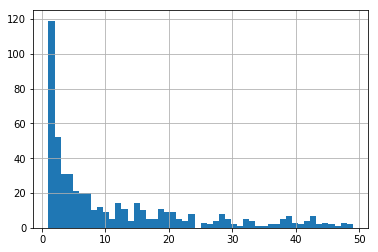

In [15]:
# check the count of observations per GENERIC_NAME
%matplotlib inline

vals = npi_drugs["GENERIC_NAME"].value_counts(sort=True, ascending=True)
vals[vals < 50].hist(bins=50) # a lot of the drugs show up very rarely on claims and so won't help
                              # as variables when trying to distinguish specialities
                              # let's remove drugs that appear on 2 or less claims
len(vals[vals > 2])

In [16]:
# check if npi_drugs is unique by NPI-drug_name-generic_name
npi_drugs_nona = npi_drugs.dropna()
unique_npi_drugs = npi_drugs_nona.duplicated(subset=["NPI","DRUG_NAME","GENERIC_NAME"],keep=False)
sum(unique_npi_drugs) # not unique

0

### The level of this dataset is not so important- for analysis purposes I think it's best to convert this dataset to the NPI-level with new variables that contain claim counts for each generic drug name (for generic drugs that appear on more than 2 claims) and capture provider drug prescription behavior this way.  I will also standardize the generic drug names by making them all upper case (and hopefully there are no spelling mistakes) and remove observations with missing data.  I assume here that brand names won't be useful for identifying cardiologists.  Given more time I could look into this, since drug marketers could target cardiologists differently.  In principle though, I don't think the brand name should matter.

### It might also be nice to do an internet search from generic drugs commonly prescribed by cardiologists (see for example, https://intermountainhealthcare.org/-/media/files/services/heart-care/table-common-meds.pdf?la=en) to reduce the number of variables here.  I'll look into this later if I have time.

### npi_specialty.csv

In [17]:
npi_specialty = pd.read_csv("npi_specialty.csv")
npi_specialty.head()

,NPI,specialty
0,1003000126,Internal Medicine
1,1003000134,Pathology
2,1003000142,Anesthesiology
3,1003000407,Family Practice
4,1003000423,Obstetrics/Gynecology


In [18]:
npi_specialty.shape

(909605, 2)

In [19]:
# check the lengths of the NPI variables (should all be 10)
npi_specialty[(npi_specialty["NPI"]/10**10 >= 1) & (npi_specialty["NPI"]/10**10 < 10)] # all 10

,NPI,specialty


In [20]:
# check if npi_specialty is unique by NPI
len(npi_specialty["NPI"].unique()) / len(npi_specialty.index) # unique

1.0

In [21]:
# check for missing values
print(npi_specialty.isnull().sum())

NPI          0
specialty    0
dtype: int64


In [22]:
# check for cardiologist specialty
print(sorted(npi_specialty["specialty"].unique())) # shows up as 'Cardiology'

['Addiction Medicine', 'All Other Suppliers', 'Allergy/Immunology', 'Ambulance Service Supplier', 'Ambulatory Surgical Center', 'Anesthesiologist Assistants', 'Anesthesiology', 'Audiologist (billing independently)', 'CRNA', 'Cardiac Electrophysiology', 'Cardiac Surgery', 'Cardiology', 'Centralized Flu', 'Certified Clinical Nurse Specialist', 'Certified Nurse Midwife', 'Chiropractic', 'Clinical Laboratory', 'Clinical Psychologist', 'Colorectal Surgery (formerly proctology)', 'Critical Care (Intensivists)', 'Dermatology', 'Diagnostic Radiology', 'Emergency Medicine', 'Endocrinology', 'Family Practice', 'Gastroenterology', 'General Practice', 'General Surgery', 'Geriatric Medicine', 'Geriatric Psychiatry', 'Gynecological/Oncology', 'Hand Surgery', 'Hematology', 'Hematology/Oncology', 'Hospice and Palliative Care', 'Independent Diagnostic Testing Facility', 'Infectious Disease', 'Internal Medicine', 'Interventional Pain Management', 'Interventional Radiology', 'Licensed Clinical Social Wor

### It looks like the npi_specialty dataset does not need much processing.  I will just enforce that the specialties are all uppercase to keep everything uniform.

### npi_proc_counts.csv

In [23]:
npi_proc_counts = pd.read_csv("npi_proc_counts.csv")
npi_proc_counts.head()

,NPI,HCPCS_CODE,LINE_SRVC_CNT,BENE_UNIQUE_CNT
0,1003000126,99222,142,138
1,1003000126,99223,96,95
2,1003000126,99231,61,47
3,1003000126,99232,777,381
4,1003000126,99233,170,106


In [24]:
npi_proc_counts.shape

(9287876, 4)

In [25]:
# check HCPCS code lengths
npi_proc_counts["length"] = npi_proc_counts.apply(lambda row: len(row["HCPCS_CODE"]), axis=1)
npi_proc_counts[npi_proc_counts["length"]!=5] # looks like HCPCS codes all have the right length
npi_proc_counts.drop("length",axis=1,inplace=True)

In [26]:
# check the lengths of the NPI variables (should all be 10)
npi_proc_counts[(npi_proc_counts["NPI"]/10**10 >= 1) & (npi_proc_counts["NPI"]/10**10 < 10)] # all 10

,NPI,HCPCS_CODE,LINE_SRVC_CNT,BENE_UNIQUE_CNT


In [27]:
# check for missing values
print(npi_proc_counts.isnull().sum()) # no missing values

NPI                0
HCPCS_CODE         0
LINE_SRVC_CNT      0
BENE_UNIQUE_CNT    0
dtype: int64


In [28]:
# check that line counts are >= 1
npi_proc_counts[npi_proc_counts["LINE_SRVC_CNT"]<1] # all >= 1

,NPI,HCPCS_CODE,LINE_SRVC_CNT,BENE_UNIQUE_CNT


In [29]:
# check that bene counts are >= 1
npi_proc_counts[npi_proc_counts["BENE_UNIQUE_CNT"]<1] # all >= 1

,NPI,HCPCS_CODE,LINE_SRVC_CNT,BENE_UNIQUE_CNT


In [30]:
# check to see if npi_proc_counts is unique by NPI-HCPCS_code
unique_npi_hcpcs = npi_proc_counts.duplicated(subset=["NPI","HCPCS_CODE"],keep=False)
sum(unique_npi_hcpcs) # not unique

541794

In [31]:
# look into non-unique values
non_unique = npi_proc_counts[npi_proc_counts[["NPI","HCPCS_CODE"]].duplicated(keep=False)]
print(len(non_unique))
print(non_unique.head(20)) # looks like a lot of providers are reporting the same HCPCS codes twice
                           # in this dataset. 
# It could be that one of this entries is incorrect and the other 
# is correct, or that the lines and benes should be summed over the duplicate NPI-HCPCS_CODE pairs.
# It would be nice if these entries had dates on them to help determine if some values are more 
# updated (or if I could reference the raw claims data).  For now I will assume that the entry 
# with a larger number of lines is more updated, and drop the other entries.

541794
            NPI HCPCS_CODE  LINE_SRVC_CNT  BENE_UNIQUE_CNT
114  1003000936      93306            137              135
115  1003000936      93306             30               30
121  1003000936      99213             34               33
122  1003000936      99213             41               37
123  1003000936      99214            104               98
124  1003000936      99214             90               75
191  1003001462      77263             29               26
192  1003001462      77263             20               20
194  1003001462      77290             48               27
195  1003001462      77290             13               13
196  1003001462      77300            169               28
197  1003001462      77300            285               35
202  1003001462      77334             80               27
203  1003001462      77334             16               14
208  1003001462      77427             60               17
209  1003001462      77427            256        

### It looks like variables in this dataset are non-missing and formatted properly.  I plan to process this data by deduping the NPI-HCPCS_CODE observations by taking the row with the largest LINE_SRVC_CNT.  Initially my plan also was to create a dataset that was unique by NPI and had a variable describing lines/bene for each HCPCS code.  However, creating this dataset will cause memory problems on my personal computer.  This is too bad, since I was interested in seeing how well different variable selection techniques identified the important variables (but this would also run slowly).

### Instead I will use HCPCS codes identified from the hcpcs_lookup dataset to subset the npi_proc_counts dataset to HCPCS codes that are related to cardiology.  (Note that in doing so I will not be making use of the drugs which do not have cardiology-related desciptions.)  When picking a list of HCPCS codes, ideally one would do more research (online or by looking at actual claims) or consult with a cardiologist.  I will also experiment with keeping a randomly selected set of the other HCPCS variables since I am not very confident in my determination of cardiology HCPCS codes and since I might be missing some HCPCS codes that cardiologists don't use but other providers commonly use (which could also be useful variables).  I also would like to see how the machine learning algorithm chooses the variables, at least in one model.  

### Note that I have not been searching for outliers.  Generally data like this (that is tied to payment) is pretty accurate.  Also it would be hard for me to judge if values are true outliers without having more context.

In [32]:
print(len(npi_proc_counts["NPI"].unique()))
print(len(npi_proc_counts["HCPCS_CODE"].unique())) # results in a ~ 3 GB dataframe

909605
5983


### generic_drugs.csv
This list of generic drugs is created from the drugs listed here: https://intermountainhealthcare.org/-/media/files/services/heart-care/table-common-meds.pdf?la=en, removing some drugs which are related to things like pain management which probably a lot of different types of providers use.

In [33]:
generic_drugs = pd.read_csv("generic_drugs.csv")
generic_drugs.head()

,GENERIC_NAME
0,benazepril
1,captopril
2,enalapril maleate
3,lisinopril
4,quinapril


In [34]:
generic_drugs.shape

(96, 1)

In [35]:
# check overlap with the npi_drugs dataset
card_drugs = generic_drugs["GENERIC_NAME"]
card_drugs = card_drugs.apply(lambda x: str(x).upper())
all_drugs = pd.Series(npi_drugs["GENERIC_NAME"].unique())
all_drugs = all_drugs.apply(lambda x: str(x).upper())
drugs_in_both = pd.Series(list(set(all_drugs).intersection(set(card_drugs))))
len(drugs_in_both)

62

### I will use only these drugs (and perhaps a small randomly selected subset of the other drugs at first, to see if it is beneficial) when processing the npi_drugs dataset.  Like in the npi_proc_counts dataset, it is important to reduce the variables in the npi_drugs dataset to reduce memory usage and build better models which can run faster.

### Now merge data together to create analysis dataset.  All future data will need to be processed through the following steps to create the analysis dataset.

In [36]:
# create functions to process each dataset and then merge them to create an analysis dataset that is
# unique at the NPI level

##################################################################################################

# import modules
import pandas as pd
import numpy as np
import random

def get_and_clean_data(Nrand,reduce_vars):

    ##################################################################################################

    # hcpcs_lookup file needs no processesing.  It was unique by HCPCS_CODE and all HCPCS_CODEs were 5 
    # digits

    # instead obtain list of (hopefully) cardiology-related HCPCS codes below

    ##################################################################################################

    # process npi_drugs file
    # drop observations with missing data
    # drop observations for generic drugs that only appear on 1 or 2 claims
    # drop observations with generic drops not in the cardiology drug list
    # create a dataset that is unique at the NPI level, and include claim count variables for each
    # generic_name variable

    def process_npi_drugs(data,card_drugs,Nrand):
        # drop observations with missing data
        data.dropna(inplace=True)

        # drop observations for generic drugs that only appear on 1 or 2 claims
        vals = data["GENERIC_NAME"].value_counts()
        vals = pd.DataFrame(vals).reset_index()
        vals.columns = ["GENERIC_NAME","COUNT"]
        common_drugs = vals[vals["COUNT"] > 2]["GENERIC_NAME"]   
        data = data[data["GENERIC_NAME"].isin(common_drugs)]

        # only keep observations with generic drugs in the list
        # also keep 100 other randomly selected drugs
        all_drugs = data["GENERIC_NAME"].unique()
        noncard_drugs = [name for name in all_drugs if name not in card_drugs]
        random.seed(2)
        random_drugs = random.sample(noncard_drugs,Nrand)
        final_drugs = list(card_drugs) + random_drugs
        data = data[data["GENERIC_NAME"].isin(final_drugs)]

        # sum claim counts
        # note this might overcount some if two different brands are reported on the same
        # claim, but hopefully this is rare
        data = data.groupby(by=["NPI","GENERIC_NAME"]).agg({"TOTAL_CLAIM_COUNT": np.sum})
        data.reset_index(level=["NPI","GENERIC_NAME"],inplace=True)

        # make sure all drug names are uppercase
        data["GENERIC_NAME"] = data["GENERIC_NAME"].apply(lambda x: str(x).upper())

        # create variables containing claim counts for each generic drug name at the NPI level
        data = data.pivot(index='NPI', columns='GENERIC_NAME', values='TOTAL_CLAIM_COUNT')
        data.reset_index(level=["NPI"],inplace=True)
        data.fillna(0,inplace=True)

        return data

    ##################################################################################################

    # process npi_specialty file by formatting the specialty variable to all uppercase

    def process_npi_specialty(data):
        # make sure all specialty titles are uppercase
        data["specialty"] = data["specialty"].apply(lambda x: str(x).upper())
        return data

    ##################################################################################################

    # process npi_proc_counts file
    # create 5-digit HCPCS_CODE variable by padding with leading zeros (just in case)
    # collapse data to NPI-HCPCS_CODE level by taking the entry with the largest number of lines
    # reduce dataset to NPI level by creating a variable describing the lines/bene for each HCPCS_CODE

    def process_npi_proc_counts(data,card_hcpcs,Nrand):

        # only keep observations with hcpcs on the hcpcs list
        # also keep 100 other randomly selected hcpcs
        all_hcpcs = data["HCPCS_CODE"].unique()
        noncard_hcpcs = [hcpcs for hcpcs in all_hcpcs if hcpcs not in card_hcpcs]
        random.seed(3)
        random_hcpcs = random.sample(noncard_hcpcs,Nrand)
        final_hcpcs = card_hcpcs + random_hcpcs
        data = data[data["HCPCS_CODE"].isin(final_hcpcs)]

        # identify and dedupe the duplicate rows by NPI-HCPCS_CODE, keeping entry with largest line 
        # counts
        dups = data[data[["NPI","HCPCS_CODE"]].duplicated(keep=False)]
        dups = dups.sort_values(["NPI","HCPCS_CODE","LINE_SRVC_CNT"],ascending=[0,0,0])
        deduped = dups.drop_duplicates(subset=["NPI","HCPCS_CODE"],keep='first')

        # stack deduped dataset and original non-duplicated dataset
        no_dups = data.drop_duplicates(subset=["NPI","HCPCS_CODE"],keep=False)
        data = pd.concat([no_dups,deduped])

        # create line per bene variable
        data["LINES_PER_BENE"] = data["LINE_SRVC_CNT"] / data["BENE_UNIQUE_CNT"]

        # drop BENE_UNIQUE_CNT and LINE_SRVC_CNT variables
        data.drop(columns=["BENE_UNIQUE_CNT","LINE_SRVC_CNT"],inplace=True)

        # aggregrate to NPI level by creating lines/bene variables for each HCPCS code
        data = data.pivot(index="NPI", columns="HCPCS_CODE", values="LINES_PER_BENE")
        data.reset_index(level=["NPI"],inplace=True)
        data.fillna(0,inplace=True)

        return data

    ########################

    def process_npi_proc_counts_v2(data):

        # only keep observations with hcpcs in range 92920 - 93998
        data = data[(data["HCPCS_CODE"] <= "93998") & (data["HCPCS_CODE"] >= "92920")]

        # identify and dedupe the duplicate rows by NPI-HCPCS_CODE, keeping entry with largest line 
        # counts 
        dups = data[data[["NPI","HCPCS_CODE"]].duplicated(keep=False)]
        dups = dups.sort_values(["NPI","HCPCS_CODE","LINE_SRVC_CNT"],ascending=[0,0,0])
        deduped = dups.drop_duplicates(subset=["NPI","HCPCS_CODE"],keep='first')

        # stack deduped dataset and original non-duplicated dataset
        no_dups = data.drop_duplicates(subset=["NPI","HCPCS_CODE"],keep=False)
        data = pd.concat([no_dups,deduped])

        # group data by first three digits of HCPCS_CODE
        data["HCPCS_CODE_3"] = data["HCPCS_CODE"].apply(lambda x: x[:3])
        data = data.groupby(by=["NPI","HCPCS_CODE_3"]).agg({"LINE_SRVC_CNT":np.sum, "BENE_UNIQUE_CNT":np.sum})
        data.reset_index(level=["NPI","HCPCS_CODE_3"],inplace=True)

        # create line per bene variable
        data["LINES_PER_BENE"] = data["LINE_SRVC_CNT"] / data["BENE_UNIQUE_CNT"]

        # drop BENE_UNIQUE_CNT and LINE_SRVC_CNT variables
        data.drop(columns=["BENE_UNIQUE_CNT","LINE_SRVC_CNT"],inplace=True)

        # aggregrate to NPI level by creating lines/bene variables for each HCPCS code
        data = data.pivot(index="NPI", columns="HCPCS_CODE_3", values="LINES_PER_BENE")
        data.reset_index(level=["NPI"],inplace=True)
        data.fillna(0,inplace=True)

        return data    
    
    ##################################################################################################

    # read in data
    hcpcs_lookup = pd.read_csv("hcpcs_lookup.csv")
    npi_drugs = pd.read_csv("npi_drugs.csv")
    npi_specialty = pd.read_csv("npi_specialty.csv")
    npi_proc_counts = pd.read_csv("npi_proc_counts.csv")
    generic_drugs = pd.read_csv("generic_drugs.csv")

    ##################################################################################################

    # obtain cardiology HCPCS and generic drug names, and process data

    # cardicac HCPCS
    card_hcpcs = []
    for i in range(len(hcpcs_lookup["HCPCS_DESCRIPTION"])):
        if "card" in hcpcs_lookup["HCPCS_DESCRIPTION"][i] and hcpcs_lookup["HCPCS_CODE"][i] != "86744":
            card_hcpcs.append(hcpcs_lookup["HCPCS_CODE"][i])

    # cardiac drugs   
    if reduce_vars == 1:
        # use only cardiology drugs identified as important by first boosted decision tree
        card_drugs = ['AMLODIPINE BESYLATE', 'ATORVASTATIN CALCIUM',
       'BECLOMETHASONE DIPROPIONATE', 'CARVEDILOL', 'CEPHALEXIN',
       'CLONIDINE HCL', 'DESVENLAFAXINE SUCCINATE', 'DIGOXIN', 'DOFETILIDE',
       'DOXAZOSIN MESYLATE', 'EPLERENONE', 'FESOTERODINE FUMARATE',
       'FLECAINIDE ACETATE', 'FUROSEMIDE', 'GEMFIBROZIL',
       'HYDROCHLOROTHIAZIDE', 'LEVETIRACETAM', 'LISINOPRIL', 'LOVASTATIN',
       'METOPROLOL SUCCINATE', 'METOPROLOL TARTRATE', 'NITROGLYCERIN',
       'PROPAFENONE HCL', 'PROPRANOLOL HCL', 'RIVASTIGMINE TARTRATE',
       'SIMVASTATIN', 'TERAZOSIN HCL']
    else:
        # all cardiology drugs from the online list
        card_drugs = generic_drugs["GENERIC_NAME"]
        card_drugs = card_drugs.apply(lambda x: str(x).upper())
    
    # process data
    npi_drugs = process_npi_drugs(npi_drugs,card_drugs,Nrand)
    if reduce_vars == 1:
        npi_proc_counts = process_npi_proc_counts_v2(npi_proc_counts)
    else:
        npi_proc_counts = process_npi_proc_counts(npi_proc_counts,card_hcpcs,Nrand)
    npi_specialty = process_npi_specialty(npi_specialty)
    
    ##################################################################################################

    # merge the datasets to create a final NPI-level dataset

    data = npi_specialty.merge(npi_proc_counts, on = "NPI", how = "left") # only want observations with
                                                                          # non-missing specialties
    del npi_specialty
    del npi_proc_counts

    data = data.merge(npi_drugs, on = "NPI", how = "left")
    del npi_drugs

    # claim count and line/bene variables should all be set to zero if they are missing
    data.fillna(0,inplace=True)

    # turn the NPI variable into an index.  The value of the NPI contains no information so it should 
    # not be used as a feature/variable in any model.
    data.set_index("NPI",inplace=True)

    # create binary indicator for cardiologist
    bool_series = data["specialty"] == "CARDIOLOGY"
    class_labels = bool_series.astype('int')
    data.drop(columns=["specialty"],inplace=True)
    
    # standardize column names
    data.columns = data.columns.str.replace(" ","_")
    
    return data, class_labels

## Step 2. Create training, and test datasets

###  A. Start off by trying a boosted decision tree.  Boosted decision trees tend to perform well for problems with structured data like this.  In addition, they are resistant to data with many irrelvant variables (as we have here) and can help generate interactions terms which could be important in this problem (i.e. cardiologists might be best identified as specialists who prescribe multiple drugs frequently).  

In [37]:
from sklearn.model_selection import train_test_split

# obtain model with random variables
data, class_labels = get_and_clean_data(Nrand=100,reduce_vars=0)
print(data.head())
print(data.shape)

# create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, class_labels, test_size=0.2, random_state=11)

            01500  01830  15277  15756  25560  26418  26992  27001  27640  \
NPI                                                                         
1003000126    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1003000134    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1003000142    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1003000407    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1003000423    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            28100       ...         TREPROSTINIL_SODIUM  TRIAMTERENE  \
NPI                     ...                                            
1003000126    0.0       ...                         0.0          0.0   
1003000134    0.0       ...                         0.0          0.0   
1003000142    0.0       ...                         0.0          0.0   
1003000407    0.0       ...                         0.0          0.0   
1003000423    0.0       ... 

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

# ignore depreciation warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

# fit the baseline model, just use default parameters
model = XGBClassifier()  
model.fit(X_train,y_train)

# make predictions for train data
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("train accuracy: ", accuracy)        

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("test accuracy: ", accuracy)

# feature importance
cols=X_test.columns
print("all features used: ",cols[model.feature_importances_ > 0])
print("most important features used: ",cols[model.feature_importances_ > 0.005])

# confusion matrix
print("confusion matrix:")
print(confusion_matrix(y_test, (y_pred>0.5)))
tn, fp, fn, tp = confusion_matrix(y_test, (y_pred>0.5)).ravel()
print("true positive rate: ",tp/(tp+fn)) # (out of actual caridiologists, fraction the model 
                                         # identifies)
print("true negative rate: ",tn/(tn+fp)) # (out of actual non-caridiologists, fraction the model 
                                         # identifies)

train accuracy:  0.9933542581670065
test accuracy:  0.9935191649122421
all features used:  Index(['929', '930', '932', '933', '934', '935', '936', '937', '938', '939',
       'AMLODIPINE_BESYLATE', 'ATORVASTATIN_CALCIUM',
       'BECLOMETHASONE_DIPROPIONATE', 'CARVEDILOL', 'CEPHALEXIN',
       'CLONIDINE_HCL', 'DESVENLAFAXINE_SUCCINATE', 'DIGOXIN', 'DOFETILIDE',
       'DOXAZOSIN_MESYLATE', 'EPLERENONE', 'FESOTERODINE_FUMARATE',
       'FLECAINIDE_ACETATE', 'FUROSEMIDE', 'GEMFIBROZIL',
       'HYDROCHLOROTHIAZIDE', 'LEVETIRACETAM', 'LISINOPRIL', 'LOVASTATIN',
       'METOPROLOL_SUCCINATE', 'NITROGLYCERIN', 'PROPAFENONE_HCL',
       'PROPRANOLOL_HCL', 'RIVASTIGMINE_TARTRATE', 'SIMVASTATIN',
       'TERAZOSIN_HCL'],
      dtype='object')
most important features used:  Index(['929', '930', '932', '933', '934', '935', '936', '937', '938', '939',
       'AMLODIPINE_BESYLATE', 'ATORVASTATIN_CALCIUM',
       'BECLOMETHASONE_DIPROPIONATE', 'CARVEDILOL', 'CEPHALEXIN',
       'CLONIDINE_HCL', 'D

In [52]:
# prediction accuracy if alway predict not a cardiologist
1-sum(y_test)/len(y_test)

0.9759785841106854

### This model was slow to train (~ 20 min) and the results were not that impressive:
* 98.9% accurate on the test set whereas a model predicting that all physicians are not cardiologists would be correct 97.6% of the time.
* The true positive rate was only 67%, so out of all cardiologists, only 67% were correctly identified.

### The model also did not use many of the features.  To try to improve model performance, I will use the important variables identified in this model to reduce the number of generic drug features.  (I added this to the processing function above).  I will also aggregate the data for the HCPCS codes by their first three digits. 

### B. Run boosted decision tree using less features.  Add cross validation to optimize over some of the model parameters.

In [53]:
# obtain model with smaller number of variables
data, class_labels = get_and_clean_data(Nrand=0,reduce_vars=1)
print(data.head())
print(data.shape)

# create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, class_labels, test_size=0.2, random_state=11)

            929  930  932  933  934  935  936  937  938  939      ...        \
NPI                                                               ...         
1003000126  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...         
1003000134  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...         
1003000142  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...         
1003000407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...         
1003000423  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...         

            LISINOPRIL  LOVASTATIN  METOPROLOL_SUCCINATE  METOPROLOL_TARTRATE  \
NPI                                                                             
1003000126        19.0         0.0                   0.0                 30.0   
1003000134         0.0         0.0                   0.0                  0.0   
1003000142         0.0         0.0                   0.0                  0.0   
1003000407        11.0         0.0       

In [54]:
print(sum(y_train)/len(y_train)) # fraction of training data that are cardiologists

0.024933899879618075


In [123]:
# parameters to optimize over
depths = [1,3,5] # tree size
#etas = [0.05,0.1,0.2] # learning rate
scale_pos_weights = [1,100] # should be set larger than 1 for imbalanced data

accuracies = np.zeros((len(depths),len(scale_pos_weights)))
accuracy_stdevs = np.zeros((len(depths),len(scale_pos_weights)))
tp_rates = np.zeros((len(depths),len(scale_pos_weights)))
tp_rate_stdevs = np.zeros((len(depths),len(scale_pos_weights)))
di = 0
train_vals = y_train.reset_index()['specialty']

# loop over parameters
for d in depths:
    si = 0
    for s in scale_pos_weights:
        
        print("depth = "+str(d)+", scale_pos_weights = "+str(s))
        
        # fit the model
        model = XGBClassifier(max_depth=d,
                              scale_pos_weight=s)  
        model.fit(X_train,y_train)
        
        # CV errors
        kfold = KFold(n_splits=3, random_state=3)
        results = cross_val_score(model, X_train, y_train, cv=kfold)
        accuracies[di,si] = results.mean()
        accuracy_stdevs[di,si] = results.std()
        print("CV accuracy: ",results.mean()," +/- ",results.std())
        
        # true positive rates on CV datasets
        cv_preds_all = cross_val_predict(model, X_train, y_train, cv=kfold)
        tp_rate_cv = []
        for train_idx, test_idx in kfold.split(X_train):
            cv_actuals = train_vals[test_idx]
            cv_actuals = cv_actuals.reset_index()['specialty']
            cv_preds = cv_preds_all[test_idx]
            cv_tp = sum([1 for i in range(len(cv_preds)) if cv_preds[i] == 1 and cv_actuals[i] == 1])
            cv_fn = sum([1 for i in range(len(cv_preds)) if cv_preds[i] == 0 and cv_actuals[i] == 1])
            tp_rate_cv.append(cv_tp / (cv_tp + cv_fn))
        tp_rates[di,si] = np.mean(tp_rate_cv)
        tp_rate_stdevs[di,si] = np.std(tp_rate_cv)
        print("CV true positive rate: ",tp_rates[di,si]," +/- ",tp_rate_stdevs[di,si])
        
        # make predictions for train data
        y_pred = model.predict(X_train)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_train, predictions)
        print("train accuracy: ", accuracy)        
        
        # make predictions for test data
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions)
        print("test accuracy: ", accuracy)
        
        # feature importance
        cols=X_test.columns
        print("most important features: ",cols[model.feature_importances_ >= 0.05])
        
        # confusion matrix
        print('Evaluated on the test set:')
        print("confusion matrix:")
        print(confusion_matrix(y_test, (y_pred>0.5)))
        tn, fp, fn, tp = confusion_matrix(y_test, (y_pred>0.5)).ravel()
        print("true positive rate: ",tp/(tp+fn)) # out of actual caridiologists, fraction the model 
                                                 # identifies, AKA recall
        print("true negative rate: ",tn/(tn+fp)) # out of actual non-caridiologists, fraction the model 
                                                 # identifies
        print("precision: ",tp/(tp+fp)) # out of all predicted cardiologists, fraction which actually
                                        # are cardiologistis
        print("-------------------------------------------------------")
        
        si += 1
    di += 1

print("all CV accuracies: ")
print(accuracies)
print("all CV accuracy standard deviations: ")
print(accuracy_stdevs)

print("all CV true positive rates")
print(tp_rates)
print("all CV true positive rate standard deviations: ")
print(tp_rate_stdevs)

depth = 1, scale_pos_weights = 1
CV accuracy:  0.9911170233478274  +/-  0.0001201623324409229
CV true positive rate:  0.7366638338516559  +/-  0.004886496930875254
train accuracy:  0.9911348882207112
test accuracy:  0.9914578305967975
most important features:  Index(['930', '932', '933', '934', 'CARVEDILOL', 'CEPHALEXIN', 'LEVETIRACETAM',
       'NITROGLYCERIN'],
      dtype='object')
Evaluated on the test set:
confusion matrix:
[[177151    400]
 [  1154   3216]]
true positive rate:  0.7359267734553776
true negative rate:  0.9977471261778306
precision:  0.8893805309734514
-------------------------------------------------------
depth = 1, scale_pos_weights = 100
CV accuracy:  0.9550532937944712  +/-  0.0019456626790053774
CV true positive rate:  0.9513246939685912  +/-  0.005451388475770244
train accuracy:  0.9553982223052864
test accuracy:  0.9557610171448047
most important features:  Index(['930', '932', '933', '934', 'CARVEDILOL', 'CEPHALEXIN'], dtype='object')
Evaluated on the test 

### The model that has the best *true positive rate* (96.2%) on the CV dataset has tree depth = 5  and weighting for positive observations =  100.  Choosing the model based on the true positive rate would be important if we were trying to identify all of the actual cardiologists more so than accurately identifying all of the non-cardiologists.  This model has a true positive rate of 96.5% on the test set.  The most important features were lines/bene for HCPCS beginning with '930', '932', '933', and the number of claims for generic drug 'CEPHALEXIN' (an oral antibiotic).  The accuracy was 97.4% and the precision was 47.5%.  Since models with tree depth > 1 performed better, this indicates that interactions between the features are important.

### The model that has the best *accuracy* (99.4%) on the CV dataset has tree depth = 5  and weighting for positive observations =  1.  This model is 99.4% accurate on the test set.  The most important features were lines/bene for HCPCS beginning with '930', '932', '933', and the number of claims for generic drug 'METOPROLOL_SUCCINATE' (treats high blood pressure).  The true positive rate/recall was 83.1% and the precision was 90.4%.  (Note that the best true positive rate (96.5%) was obtained with tree depth = 5 and weighting for positive observations = 100, with a lower total test accuracy of 97.4% and lower precision of 47.5%).  

### To get some intuition about the model with the best overall accuracy, we can look at a plot of the feature importance values as well as plotting the first tree that gets built in the boosted model.

In [43]:
# most overall accurate model
d = 5
s = 1
model5 = XGBClassifier(max_depth=d,
                      scale_pos_weight=s)  
model5.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

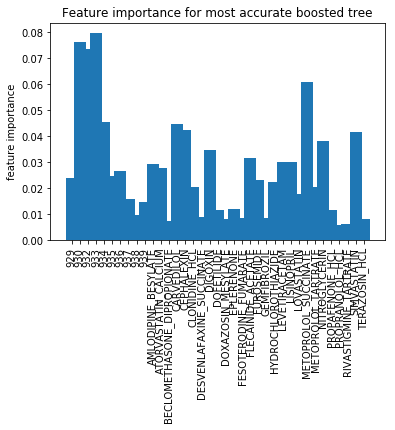

In [44]:
from matplotlib import pyplot as plt
from xgboost import plot_tree

cols=X_test.columns
plt.bar(cols, model5.feature_importances_,width=1.5)
plt.xticks(cols, rotation='vertical')
plt.ylabel("feature importance")
plt.title("Feature importance for most accurate boosted tree")
plt.show()

In [45]:
# model with tree depth of 3 (not most accurate, but easier to visualize and follow) 
d = 3
s = 1
model3 = XGBClassifier(max_depth=d,
                       scale_pos_weight=s)  
model3.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

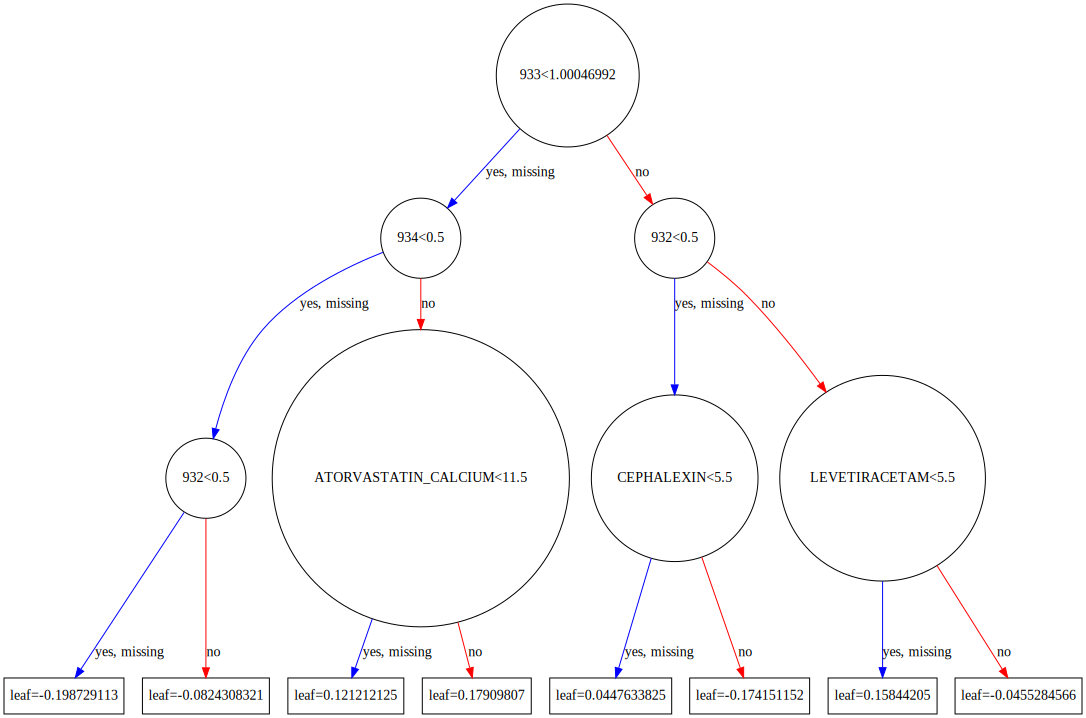

In [46]:
from xgboost import to_graphviz
to_graphviz(model3) # leaf node shows raw score for being a cardiologist
                    # can convert to probability using the logistic function
                    # negative values --> prob of being cardiologist < 50%
                    # positive values --> prob of being cardiologist > 50%

In [47]:
# dump the model trees
model3._Booster.dump_model("model3_dump.txt")

#### First tree in the model (copied from model3_dump.txt):

booster[0]:

0:[933<1.00046992] yes=1,no=2,missing=1

	1:[934<0.5] yes=3,no=4,missing=3
		3:[932<0.5] yes=7,no=8,missing=7
			7:leaf=-0.198729113
			8:leaf=-0.0824308321
		4:[ATORVASTATIN_CALCIUM<11.5] yes=9,no=10,missing=9
			9:leaf=0.121212125
			10:leaf=0.17909807
	2:[932<0.5] yes=5,no=6,missing=5
		5:[CEPHALEXIN<5.5] yes=11,no=12,missing=11
			11:leaf=0.0447633825
			12:leaf=-0.174151152
		6:[LEVETIRACETAM<5.5] yes=13,no=14,missing=13
			13:leaf=0.15844205
			14:leaf=-0.0455284566

In [48]:
# check where training data ended up
terminal_nodes = model3.apply(X_train,ntree_limit=1)
pd.Series(terminal_nodes).value_counts() # most cardiologists end up in terminal node 13
# terminal node 13 has 933 >= 1, 932 >= 0.5, and Levetiracetam < 13
# levetiracetam is a drug for treating seizures that was initially found to be important using the 
# random variable search approach.

7     704386
13     10805
11      5152
8       4225
10      1393
12       909
14       488
9        326
dtype: int64

## Summary

### I started off by cleaning the data and determining how to combine the datasets to make a final dataset to run a machine learning algorithm on.  Missing values and duplicated observations were addressed.  I also generated lists of cardiology-related HCPCS codes and created a dataset containing common generic drugs for cardiology based off of a website online.

### I first ran a baseline boosted decision tree model using all HCPCS codes that contain "card", all generic drugs on the cardiology drug list from online, and some randomly selected HCPCS codes and generic drugs (in case they might be relevant too).  I choose to use boosted decision trees because they are better than other models at handling irrelevant variables.  Boosted decision trees can also be used to learn interaction terms between the features and tend to perform well for problems with unstructured data in general.

### Since the first model did not perform very well and was slow to run, I tried aggregating the HCPCS code variables by their first three digits as well as reducing the number of generic drug name variables by restricting to the most important variables found in the baseline model.  I also optimized over a range of values for the tree depth and looked at the effects of changing the weighting for positive observations.

### The most accurate model used tree depth = 5 and weight for positive observations = 1.  It was 99.4% accurate with a true positive rate/recall of 83.1% and a precision of 90.4%.  The best models had larger trees indicating that feature interactions are an important for describing the data.  The model with the highest true positive rate used tree depth = 5 and weight for positive observations = 100.  It had a true positive rate of 96.5%, with lower accuracy of 97.4% and lower precision of 47.5%.

### The feature importance for the most accurate model (depth = 5) and plot of the first tree for the depth = 3 model show that reporting lines/bene for HCPCS codes beginning with 930, 932, 933, and 934 are important variables to split on.  Following the tree paths it seems more lines/bene for 933 indicate higher likelihoods of being a cardiologist.  Most cardiologists (terminal node 13) are categorized by having lines/bene for HCPCS codes beginning with 933 greater than 1, lines/bene for HCPCS codes beginning with 932 greater than 0.5, and a count of Levetiracetam claims < 13 (note this is a generic drug to treat seizures that was identified as important in the randomized variable search).  Most non-cardiologists (terminal node 7) are categorized by having low values for lines/bene for HCPCS beginning with 933, 934, and 932. 

## Future directions if I had more time:

* Spend more time doing feature selection:
    * It seems like grouping the lines/bene for the HCPCS codes was a good method to reduce the number of variables and improve accuracy, so maybe this method could be applied to the claim counts for each generic drug by grouping the drugs into categories.
    * Look more at some HCPCS codes that were missed (such as the G-codes identified above and codes which apply to cardiology but it's difficult to tell from the description)
    * If I had access to the original claims, I could generate groups of cardiology HCPCS and generic drugs by looking just at the claims from the known cardiologists in the training data.
* Look more into which specialties are getting confused with cardiologists in the models:
    * If the cardiologists are being confused with cardiac surgeons for example, it might help to include surgery-related features to distinguish these two categories.
* Optimize over more xgboost model parameters (e.g. the learning rate and the total number of trees).
* Compare different xgboost models using precision-recall curves and F1 scores.
* If I could reduce the number of features further, it would be interesting to just focus on those features and use a logistic regression model or SVM to explore the model fits/feature interactions using plots.